- import modules

In [389]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy
import scipy as sp
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

## Part-a

- Since the fraction of the population that has covid gives us the success rate of covid cases. So with $p=\gamma$, we have
$$
L(n_p,n_n|X_p,X_n,\gamma,\kappa,\tau) = \prod_{i=1}^N B(\gamma,N,n_p)\\
= \prod_{i=1}^N (1-\gamma)^{I_n}(\gamma)^{I_p}\\
= (1-\gamma)^{n_n}(\gamma)^{n_p}
$$

## Part-b

## Part-c

In [390]:
#  set some global constants
N_ITER=1e5 # no of iteration gibbs sampler iterates
ERR=1e-3 # error thershold criterian
REPRODUCE_SEED=1 # seed value for re-producibility of results

In [391]:
def gibbsSampler(**kwargs):
    """
    function to generate gibbs samples for posterior distribution
    TODO: implement stopping criterian
    TODO: implement multiple chains sampling
    """
    global REPRODUCE_SEED
    numpy.random.seed(REPRODUCE_SEED)
    
    samples_k=[kwargs['init_k']]
    samples_t=[kwargs['init_t']]
    samples_g=[kwargs['init_g']]
    samples_xn=[kwargs['init_xn']]
    samples_xp=[kwargs['init_xp']]

    curr_err=1e5
    # if we start from 0 then get n_iter+1 samples
    # so to keep sample count equal to n_iter, start from 1 
    curr_iter=1
    while(curr_iter<kwargs['n_iter']): # and curr_err>err 
        samples_k.append(numpy.random.beta(a=samples_xp[-1]+kwargs['ak'],b=samples_xn[-1]+kwargs['bk']))
        samples_t.append(numpy.random.beta(a=kwargs['nn']-samples_xn[-1]+kwargs['at'],b=kwargs['np']-samples_xp[-1]+kwargs['bt']))
        samples_g.append(numpy.random.beta(a=samples_xn[-1]+samples_xp[-1]+kwargs['ag'],b=kwargs['nn']+kwargs['np']-samples_xn[-1]-samples_xp[-1]+kwargs['bg']))
        
        tmp_pn=(samples_g[-1]*(1-samples_k[-1]))/(samples_g[-1]*(1-samples_k[-1])+(1-samples_g[-1])*samples_t[-1])
        tmp_pp=(samples_g[-1]*samples_k[-1])/(samples_g[-1]*samples_k[-1]+(1-samples_g[-1])*(1-samples_t[-1]))
        samples_xn.append(numpy.random.binomial(n=kwargs['nn'],p=tmp_pn))
        samples_xp.append(numpy.random.binomial(n=kwargs['np'],p=tmp_pp))

        curr_iter+=1
        # print(curr_iter)
        # curr_err=np.abs()
    
    samples_df=pd.DataFrame({'k':samples_k,'t':samples_t,'g':samples_g,'xn':samples_xn,'xp':samples_xp})

    return samples_df

In [392]:
def setParameters(ak,bk,at,bt,ag,bg,nn,np):
    """
    function to set parameters for gibbs sampler func
    """
    # set key variables
    keys_=['ak','bk','at','bt','ag','bg','nn','np','init_k','init_t','init_g','init_xn','init_xp','err','n_iter']
    values_=[ak,bk,at,bt,ag,bg,nn,np]
    # add beta distribution init values
    values_.append(values_[0]/(values_[0]+values_[1]))
    values_.append(values_[2]/(values_[2]+values_[3]))
    values_.append(values_[4]/(values_[4]+values_[5]))
    # add binomoal distribution init values
    init_xp=values_[7]*((values_[10]*values_[8])/(values_[10]*values_[8]+((1-values_[8])*(1-values_[9]))))
    init_xn=values_[6]*((values_[10]*(1-values_[8]))/(values_[10]*(1-values_[8])+((1-values_[8])*values_[9])))
    values_.append(init_xn)
    values_.append(init_xp)
    values_.append(ERR)
    values_.append(N_ITER)
    kwargs=dict(zip(keys_,values_))
    return kwargs

In [393]:
def plotData(sample_data,title_text):
    """
    function to plot trace and density diagrams for data 
    """
    summary_data=az.summary(sample_data)
    print(f'for {title_text}'.center(50,'='))
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
    sns.kdeplot(sample_data,bw=0.2,c='m',label='density',ax=ax1) # bw: bandwidth(amount of smoothness)
    ax1.set_xlim(0,1)
    ax1.set_title(f'density plot for {title_text}')
    ax1.axvline(summary_data['mean'].values,label='mean',c='r')
    # ax1.axvline(summary_data['hdi_3%'].values,label='hdi_3',c='g')
    # ax1.axvline(summary_data['hdi_97%'].values,label='hdi_97',c='b')
    ax1.legend()

    plt.plot(sample_data,c='m')
    plt.title(f'trace plot for {title_text}')
    plt.xlabel('sample index')
    plt.ylabel('samples')
    plt.grid()
    plt.show()
    

In [394]:
def showResults(ak,bk,at,bt,ag,bg,nn,np):
    """
    collective function that shows results
    """
    kwargs=setParameters(ak,bk,at,bt,ag,bg,nn,np)
    samples=gibbsSampler(**kwargs)
    plotData(numpy.array(samples['k']),'kappa')
    plotData(numpy.array(samples['t']),'tau')
    plotData(numpy.array(samples['g']),'gamma')

## Part-d

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for kappa=====================


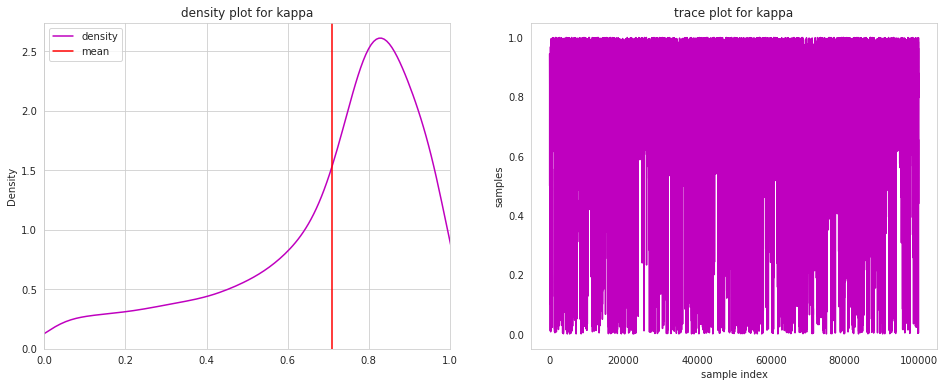

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


=====================for tau======================


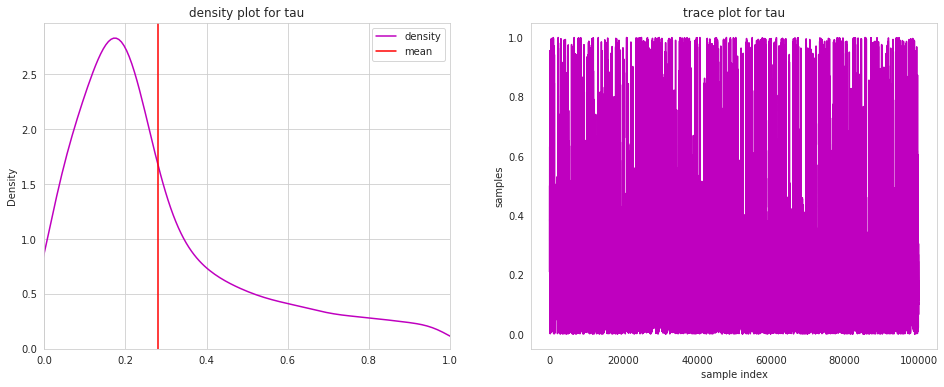

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for gamma=====================


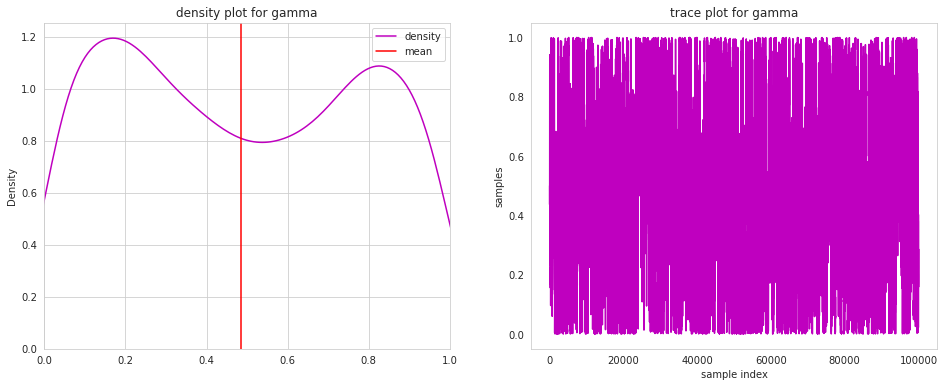

In [395]:
showResults(1,1,1,1,1,1,20,80)

**observation**
- for gamma
    - posterior mean is around 0.5 same as prior mean.
    - posterior samples cover whole sample space that is (0,1) 
- it implies that prevelance of disease is about 50% on average, so about 50% of population has covid.

## Part-e

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for kappa=====================


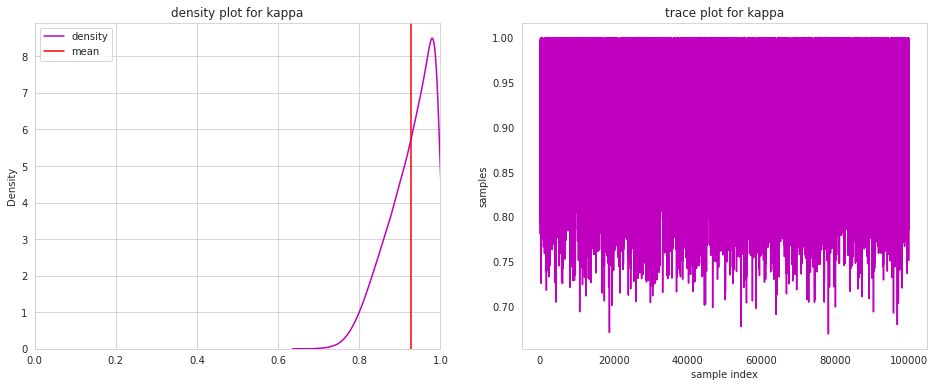

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


=====================for tau======================


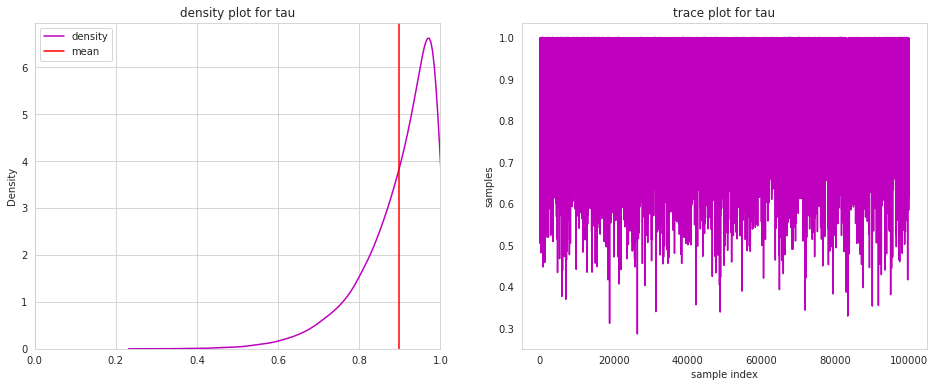

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for gamma=====================


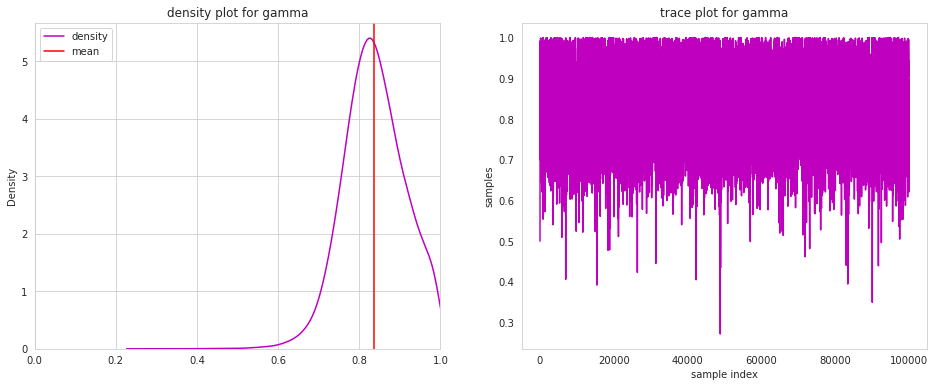

In [396]:
showResults(10,1,10,1,1,1,20,80)

**observation**
- for gamma
    - posterior mean quite high around 0.85.
    - posterior samples are skewed towards 1
- here prevelance of disease is about 85% on average, so about 85% of population has covid.
- compare: part-d has almost equally spread samples in sample sapce, but part-e samples are skewed towards 1.

## Part-f

**observation**
- kappa has almost uniform posterior distribution. and its mean is about 0.5; that implies that the true positive rate is almost 50% on average. it also shows that the true positive rate could be any value between 0 and 1 with almost equal probability, although note that on edges probability is bit low.
    - on average almost 50% of the people their covid +ve test correct, that is good.
    - from particular realization perspective, good or bad true +ve rates seems random because they are almost equally probable. 
- tau: the true negative rate is quite concentrated between 0.1 to 0.3. on average tau value is around 0.2, 
    - on average only 20% of the people who get covid -ve test reports, have actual covid -ve results. so 80% of the time people get -ve results when they in actually have +ve covid symptoms.

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for kappa=====================


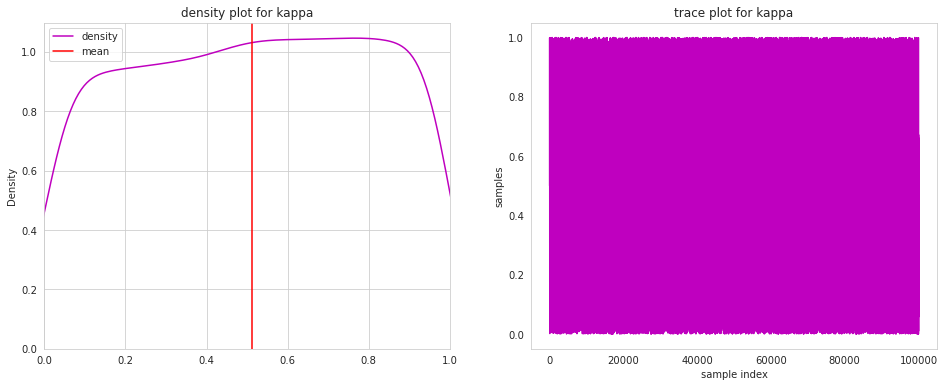

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


=====================for tau======================


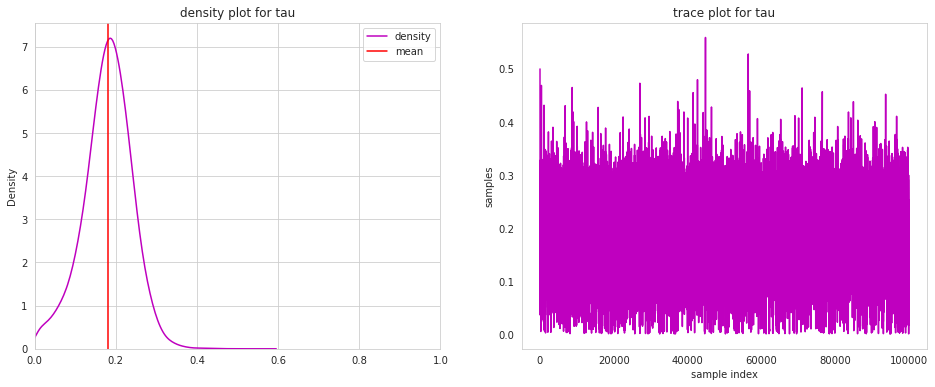

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for gamma=====================


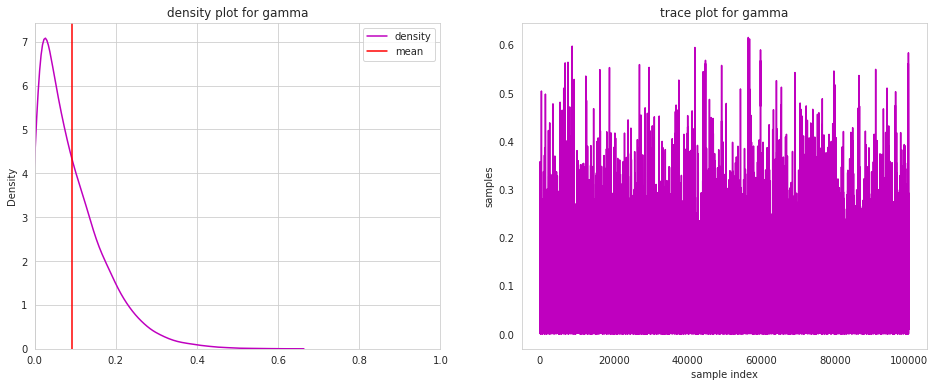

In [397]:
showResults(1,1,1,1,1,10,20,80)

## Part-g

**observation**
- posterior of kappa is skewed towards 1. on average around 80% of the people who get covid +ve test results, are correct test results. that also implies that on average 20% of the people will get -ve test reports even though they have covid. 

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for kappa=====================


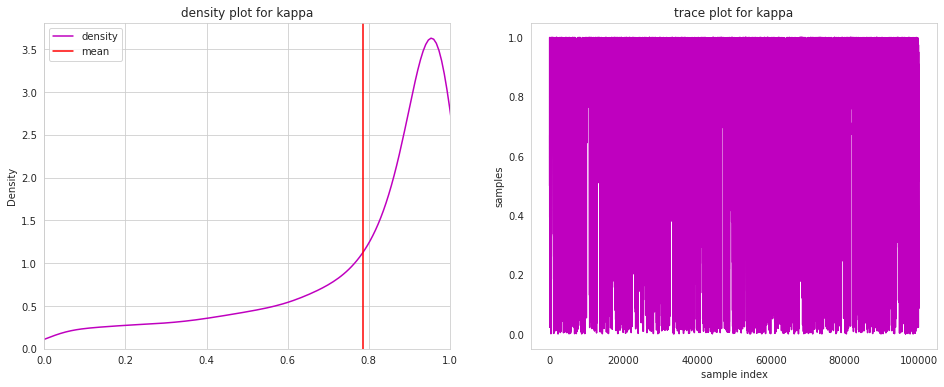

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


=====================for tau======================


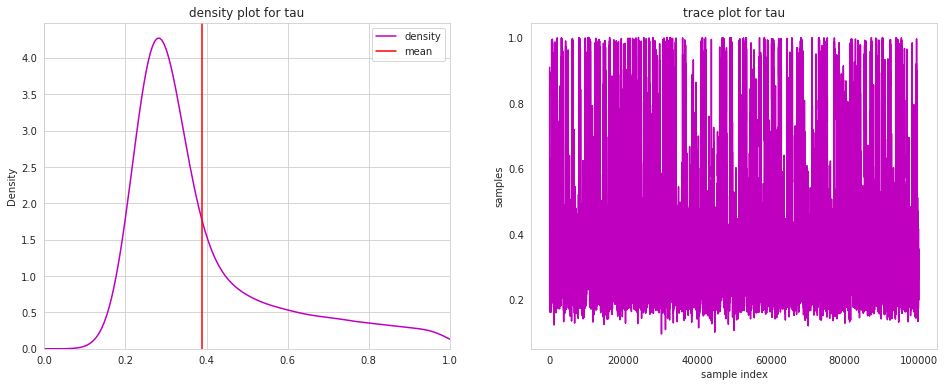

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for gamma=====================


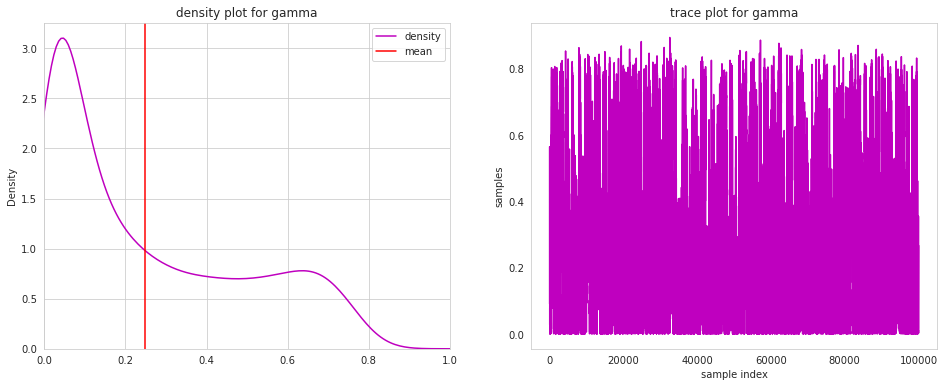

In [398]:
showResults(1,1,10,1,1,10,20,80)

## Part-h

**observation**
- posterior of kappa is skewed towards 1. on average around 80% of the people who get covid +ve test results, are correct test results. that also implies that on average 20% of the people will get -ve test reports even though they have covid. 
- observation is simlar to part-g, but note that trace plot in this case is not equally spread over iterations, chain samples are skewed towards 1

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for kappa=====================


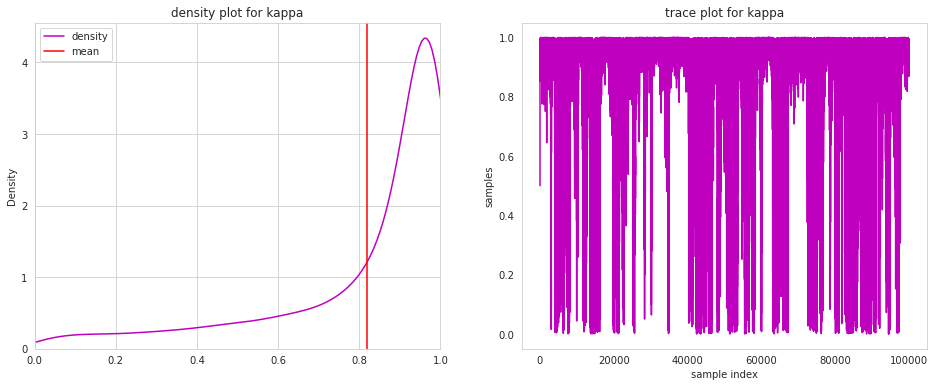

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


=====================for tau======================


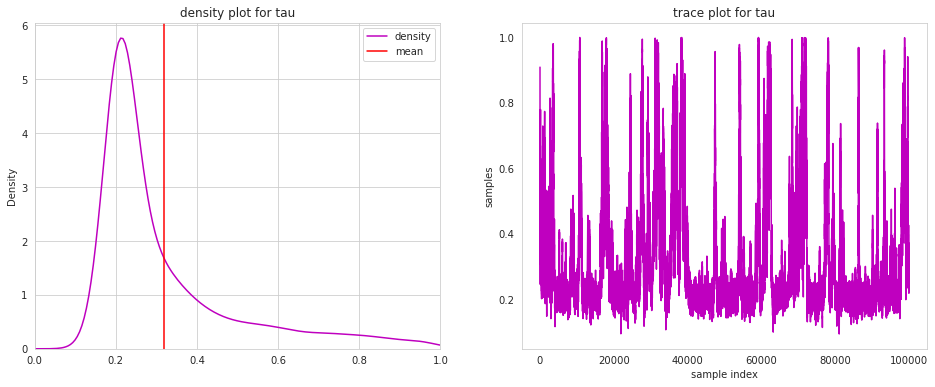

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for gamma=====================


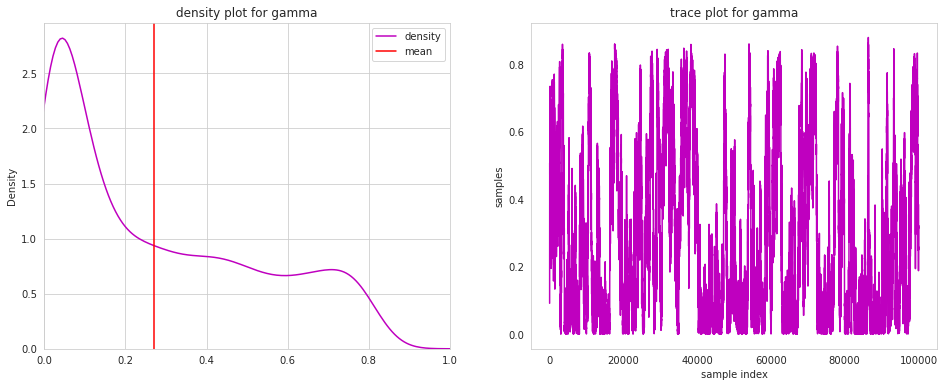

In [399]:
showResults(1,1,10,1,1,10,200,800)

## Part-i

- what is proper value for $\kappa$?
- to get proper values of $\kappa$ we can simulate it with prior $\beta(10,1)$

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for kappa=====================


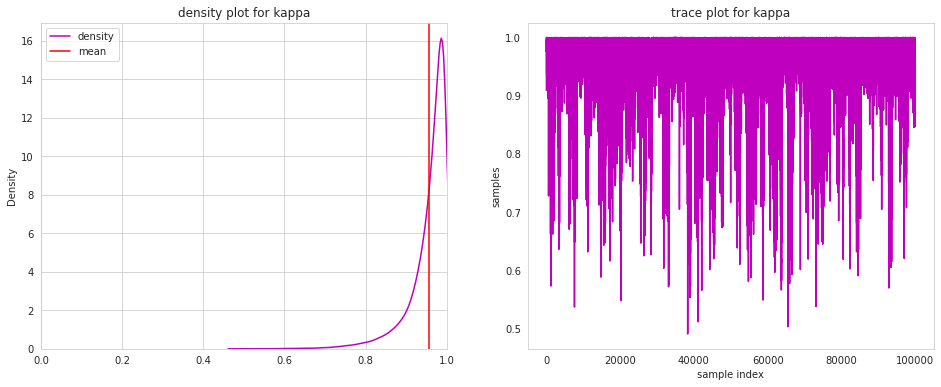

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


=====================for tau======================


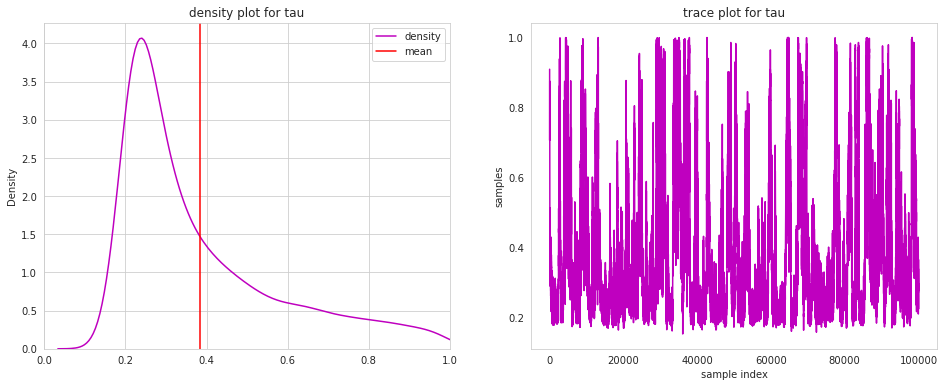

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


====================for gamma=====================


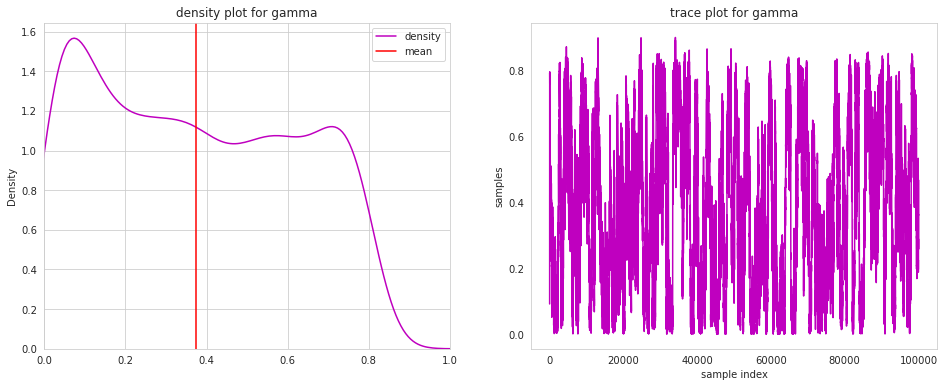

In [401]:
showResults(10,1,10,1,1,10,200,800)